In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

2022-12-06 18:06:31.295256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 18:06:31.432992: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2022-12-06 18:06:31.433011: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-06 18:06:33.075507: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No s

In [2]:
random_seed = 69
np.random.seed(random_seed)

df = pd.read_csv('munster_hourly.csv', parse_dates=["DATUM"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATUM        35672 non-null  datetime64[ns]
 1   STATIONS_ID  35672 non-null  int64         
 2   QN_4         35672 non-null  int64         
 3   TT_TER       35672 non-null  float64       
 4   RF_TER       35672 non-null  float64       
 5   VGSL         35672 non-null  float64       
 6   TS05         35672 non-null  float64       
 7   BF10         35672 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 2.2 MB


In [5]:
df = df[["DATUM", "BF10"]]
df['BF10'] = df["BF10"].astype('float32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATUM   35672 non-null  datetime64[ns]
 1   BF10    35672 non-null  float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 418.2 KB


In [6]:
TIME_WINDOW=100
FORECAST_DISTANCE=30

targetcol = "BF10"
targetcol_series = df[targetcol]

X_train, X_else, targetcol_series_train, targetcol_series_else = train_test_split(df, 
                                   targetcol_series, 
                                   test_size=0.2, 
                                   shuffle=False)
X_valid, X_test, targetcol_series_valid, targetcol_series_test = train_test_split(X_else, targetcol_series_else, test_size=0.5, shuffle=False)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print()
print(targetcol_series_train.shape)
print(targetcol_series_valid.shape)
print(targetcol_series_test.shape)

(28537, 2)
(3567, 2)
(3568, 2)

(28537,)
(3567,)
(3568,)


In [7]:
def sliding_window_2D_from_df(df, targetcol_series, TIME_WINDOW, FORECAST_DISTANCE):
    X_df = pd.concat([df.shift(i) for i in range(1,TIME_WINDOW+1)], axis=1)\
                      .iloc[TIME_WINDOW : len(df) - FORECAST_DISTANCE + 1]
    X_df.columns = pd.MultiIndex.from_product([range(1,TIME_WINDOW+1), df.columns])
    X_df.rename_axis(["lag", "variable"], axis=1, inplace=True)

    y_series = targetcol_series.shift( -FORECAST_DISTANCE + 1 )\
                      .iloc[ TIME_WINDOW : len(df) - FORECAST_DISTANCE + 1 ]
    return X_df, y_series

In [8]:
def spot_check_sliding_window_2D(X_df, y_series, df, target_series, FORECAST_DISTANCE=1):
    TIME_WINDOW = X_df.shape[1] // df.shape[1]
    display(X_df.head(1).iloc[:,[*list(range(2*df.shape[1])), *list(range(-2*df.shape[1],0))]])
    print("The following should be the first two lagged values:")
    display(df.iloc[:TIME_WINDOW].tail(2))
    print("The following should be the last two lagged values:")
    display(df.head(2))

    print(f"\nThe target (FORECAST_DISTANCE={FORECAST_DISTANCE}):")
    display(y_series.iloc[:10].to_frame().T)
    print(f"The actual values from the end of the first time window (TIME_WINDOW={TIME_WINDOW}):")
    display(target_series.iloc[TIME_WINDOW:].iloc[:FORECAST_DISTANCE+9].to_frame().T)

In [9]:
X_df_train, y_train = sliding_window_2D_from_df(X_train, targetcol_series_train, TIME_WINDOW, FORECAST_DISTANCE)
X_df_valid, y_valid = sliding_window_2D_from_df(X_valid, targetcol_series_valid, TIME_WINDOW, FORECAST_DISTANCE)
X_df_test, y_test = sliding_window_2D_from_df(X_test, targetcol_series_test, TIME_WINDOW, FORECAST_DISTANCE)

In [10]:
spot_check_sliding_window_2D(X_df_train, y_train, X_train, targetcol_series_train, FORECAST_DISTANCE)

lag                      1                         2          \
variable               DATUM  BF10               DATUM  BF10   
100      1991-02-03 07:00:00  97.0 1991-02-02 21:00:00  97.0   

lag                      99                         100         
variable               DATUM   BF10               DATUM   BF10  
100      1991-01-01 14:00:00  102.0 1991-01-01 07:00:00  102.0

The following should be the first two lagged values:


,DATUM,BF10
98,1991-02-02 21:00:00,97.0
99,1991-02-03 07:00:00,97.0


The following should be the last two lagged values:


,DATUM,BF10
0,1991-01-01 07:00:00,102.0
1,1991-01-01 14:00:00,102.0



The target (FORECAST_DISTANCE=30):


,100,101,102,103,104,105,106,107,108,109
BF10,99.0,99.0,99.0,100.0,100.0,100.0,106.0,106.0,106.0,102.0


The actual values from the end of the first time window (TIME_WINDOW=100):


,100,101,102,103,104,105,106,107,108,109,...,129,130,131,132,133,134,135,136,137,138
BF10,97.0,97.0,97.0,97.0,97.0,96.0,96.0,96.0,96.0,96.0,...,99.0,99.0,99.0,100.0,100.0,100.0,106.0,106.0,106.0,102.0


In [11]:
## where we are at...: something we can feed into generic models (e.g., feedfwd NN's, sklearn models like RF...)
X_df_train

lag                      1                          2           \
variable               DATUM   BF10               DATUM   BF10   
100      1991-02-03 07:00:00   97.0 1991-02-02 21:00:00   97.0   
101      1991-02-03 14:00:00   97.0 1991-02-03 07:00:00   97.0   
102      1991-02-03 21:00:00   97.0 1991-02-03 14:00:00   97.0   
103      1991-02-04 07:00:00   97.0 1991-02-03 21:00:00   97.0   
104      1991-02-04 14:00:00   97.0 1991-02-04 07:00:00   97.0   
...                      ...    ...                 ...    ...   
28503    2017-01-04 18:00:00  109.0 2017-01-04 12:00:00  109.0   
28504    2017-01-05 06:00:00  104.0 2017-01-04 18:00:00  109.0   
28505    2017-01-05 12:00:00  104.0 2017-01-05 06:00:00  104.0   
28506    2017-01-05 18:00:00  104.0 2017-01-05 12:00:00  104.0   
28507    2017-01-06 06:00:00  104.0 2017-01-05 18:00:00  104.0   

lag                      3                          4           \
variable               DATUM   BF10               DATUM   BF10   
100      1991-02-02 14:00:00   97.0 1991-02-02 07:00:00   97.0   
101      1991-02-02 21:00:00   97.0 1991-02-02 14:00:00   97.0   
102      1991-02-03 07:00:00   97.0 1991-02-02 21:00:00   97.0   
103      1991-02-03 14:00:00   97.0 1991-02-03 07:00:00   97.0   
104      1991-02-03 21:00:00   97.0 1991-02-03 14:00:00   97.0   
...                      ...    ...                 ...    ...   
28503    2017-01-04 06:00:00  109.0 2017-01-03 18:00:00  102.0   
28504    2017-01-04 12:00:00  109.0 2017-01-04 06:00:00  109.0   
28505    2017-01-04 18:00:00  109.0 2017-01-04 12:00:00  109.0   
28506    2017-01-05 06:00:00  104.0 2017-01-04 18:00:00  109.0   
28507    2017-01-05 12:00:00  104.0 2017-01-05 06:00:00  104.0   

lag                      5           ...                 96          \
variable               DATUM   BF10  ...               DATUM   BF10   
100      1991-02-01 21:00:00   97.0  ... 1991-01-02 14:00:00  110.0   
101      1991-02-02 07:00:00   97.0  ... 1991-01-02 21:00:00  110.0   
102      1991-02-02 14:00:00   97.0  ... 1991-01-03 07:00:00  110.0   
103      1991-02-02 21:00:00   97.0  ... 1991-01-03 14:00:00  110.0   
104      1991-02-03 07:00:00   97.0  ... 1991-01-03 21:00:00  110.0   
...                      ...    ...  ...                 ...    ...   
28503    2017-01-03 12:00:00  102.0  ... 2016-12-04 06:00:00   97.0   
28504    2017-01-03 18:00:00  102.0  ... 2016-12-04 12:00:00   97.0   
28505    2017-01-04 06:00:00  109.0  ... 2016-12-04 18:00:00   97.0   
28506    2017-01-04 12:00:00  109.0  ... 2016-12-05 06:00:00   97.0   
28507    2017-01-04 18:00:00  109.0  ... 2016-12-05 12:00:00   97.0   

lag                      97                         98          \
variable               DATUM   BF10               DATUM   BF10   
100      1991-01-02 07:00:00  110.0 1991-01-01 21:00:00  102.0   
101      1991-01-02 14:00:00  110.0 1991-01-02 07:00:00  110.0   
102      1991-01-02 21:00:00  110.0 1991-01-02 14:00:00  110.0   
103      1991-01-03 07:00:00  110.0 1991-01-02 21:00:00  110.0   
104      1991-01-03 14:00:00  110.0 1991-01-03 07:00:00  110.0   
...                      ...    ...                 ...    ...   
28503    2016-12-03 18:00:00   98.0 2016-12-03 12:00:00   98.0   
28504    2016-12-04 06:00:00   97.0 2016-12-03 18:00:00   98.0   
28505    2016-12-04 12:00:00   97.0 2016-12-04 06:00:00   97.0   
28506    2016-12-04 18:00:00   97.0 2016-12-04 12:00:00   97.0   
28507    2016-12-05 06:00:00   97.0 2016-12-04 18:00:00   97.0   

lag                      99                         100         
variable               DATUM   BF10               DATUM   BF10  
100      1991-01-01 14:00:00  102.0 1991-01-01 07:00:00  102.0  
101      1991-01-01 21:00:00  102.0 1991-01-01 14:00:00  102.0  
102      1991-01-02 07:00:00  110.0 1991-01-01 21:00:00  102.0  
103      1991-01-02 14:00:00  110.0 1991-01-02 07:00:00  110.0  
104      1991-01-02 21:00:00  110.0 1991-01-02 14:00:00  110.0  
...                      ...    ...         

In [12]:
def rolled_X_from_2D_sliding_window_df(X_df, timesteps):
    X_rolled = X_df.values.reshape(X_df.shape[0], timesteps, -1)
    return X_rolled

In [13]:
X_rolled_train = rolled_X_from_2D_sliding_window_df(X_df_train, TIME_WINDOW)
X_rolled_valid = rolled_X_from_2D_sliding_window_df(X_df_valid, TIME_WINDOW)
X_rolled_test = rolled_X_from_2D_sliding_window_df(X_df_test, TIME_WINDOW)

In [14]:
print(y_train.shape)
print(X_df_train.shape)
print(X_rolled_train.shape)

print()

print(y_test.shape)
print(X_df_test.shape)
print(X_rolled_test.shape)

(28408,)
(28408, 200)
(28408, 100, 2)

(3439,)
(3439, 200)
(3439, 100, 2)


In [15]:
## Quick data prep that is intuitively a good starting point

VALID_AND_TEST_SIZE = 0.1
TIME_WINDOW=100
FORECAST_DISTANCE=30

targetcol = "BF10"
targetcol_series = df[targetcol]

## train valid test split
X_train, X_else, targetcol_series_train, targetcol_series_else = train_test_split(df[["BF10"]], 
                                   targetcol_series, 
                                   test_size=VALID_AND_TEST_SIZE*2, 
                                   shuffle=False)
X_valid, X_test, targetcol_series_valid, targetcol_series_test = train_test_split(X_else, targetcol_series_else, test_size=0.5, shuffle=False)

## sliding window
X_df_train, y_train = sliding_window_2D_from_df(X_train, targetcol_series_train, TIME_WINDOW, FORECAST_DISTANCE)
X_df_valid, y_valid = sliding_window_2D_from_df(X_valid, targetcol_series_valid, TIME_WINDOW, FORECAST_DISTANCE)
X_df_test, y_test = sliding_window_2D_from_df(X_test, targetcol_series_test, TIME_WINDOW, FORECAST_DISTANCE)

## for lstm
X_rolled_train = rolled_X_from_2D_sliding_window_df(X_df_train, TIME_WINDOW)
X_rolled_valid = rolled_X_from_2D_sliding_window_df(X_df_valid, TIME_WINDOW)
X_rolled_test = rolled_X_from_2D_sliding_window_df(X_df_test, TIME_WINDOW)

print(X_rolled_train.shape)

(28408, 100, 1)


In [17]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras import backend as be
import tensorflow as tf

## we use 10 samples
## and 4 units (hidden state is 4-long for each time step)

tf.random.set_seed(42)
be.clear_session()
input_layer = X_rolled_train[:10]

whole_seq_output, final_memory_state, final_carry_state =  LSTM(4, return_sequences=True, return_state=True)(input_layer)

tf.random.set_seed(42)
be.clear_session()
whole_seq_output2 =  LSTM(4, return_sequences=True, return_state=False)(input_layer)

tf.random.set_seed(42)
be.clear_session()
out_last =  LSTM(4, return_sequences=False, return_state=False)(input_layer)

tf.random.set_seed(42)
be.clear_session()
whole_seq_output3, final_memory_state3, final_carry_state3 =  LSTM(4, return_sequences=False, return_state=True)(input_layer)


print("return_sequences=True, return_state=True")
print(whole_seq_output.shape)
print(final_memory_state.shape)
print(final_carry_state.shape)

print()
print("return_sequences=True, return_state=False")
print(whole_seq_output2.shape)

print()
print("return_sequences=False, return_state=False")
print(out_last.shape)

print()
print("return_sequences=False, return_state=True")
print(whole_seq_output3.shape)
print(final_memory_state3.shape)
print(final_carry_state3.shape)

return_sequences=True, return_state=True
(10, 100, 4)
(10, 4)
(10, 4)

return_sequences=True, return_state=False
(10, 100, 4)

return_sequences=False, return_state=False
(10, 4)

return_sequences=False, return_state=True
(10, 4)
(10, 4)
(10, 4)


In [21]:
EPOCHS = 10
BATCH_SIZE = 300
LEARNING_RATE = 0.1
N_CELLS = 50
KERNEL = 'GlorotNormal'

In [23]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras import backend as be
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

## number of input variables: the final dimension in the 3D prepared data (index 2)
column_count=X_rolled_train.shape[2]

be.clear_session()

model = Sequential()
model.add(LSTM(N_CELLS, activation='tanh', kernel_initializer=KERNEL, return_sequences=True, input_shape = (TIME_WINDOW, column_count)))
model.add(Dropout(0.2))

model.add(LSTM(units = N_CELLS, activation='tanh', kernel_initializer=KERNEL, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = N_CELLS, activation='tanh', kernel_initializer=KERNEL, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = N_CELLS))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

optimizer = Adam(learning_rate=LEARNING_RATE)

## remember, we're doing regression, so choose loss (and output layer) accordingly!
model.compile(loss='mean_squared_error', optimizer='adam')

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_2 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [24]:
history = model.fit(x=X_rolled_train,
                    y=y_train, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_rolled_valid,y_valid), 
                    epochs=EPOCHS,
                    verbose=1, 
                    shuffle=False,
                    )

Epoch 1/10
95/95 [==============================] - 46s 410ms/step - loss: 5550.6968 - val_loss: 3496.9043
Epoch 2/10
95/95 [==============================] - 36s 376ms/step - loss: 4730.1431 - val_loss: 3118.8386
Epoch 3/10
95/95 [==============================] - 35s 370ms/step - loss: 4223.8320 - val_loss: 2814.9678
Epoch 4/10
95/95 [==============================] - 35s 364ms/step - loss: 3790.5034 - val_loss: 2563.9836
Epoch 5/10
95/95 [==============================] - 34s 361ms/step - loss: 3416.2383 - val_loss: 2357.1038
Epoch 6/10
95/95 [==============================] - 34s 360ms/step - loss: 3088.3865 - val_loss: 2188.2095
Epoch 7/10
95/95 [==============================] - 34s 360ms/step - loss: 2809.5481 - val_loss: 2052.6431
Epoch 8/10
95/95 [==============================] - 34s 359ms/step - loss: 2562.7039 - val_loss: 1945.8113
Epoch 9/10
95/95 [==============================] - 34s 359ms/step - loss: 2352.6436 - val_loss: 1863.9562
Epoch 10/10
95/95 [==================

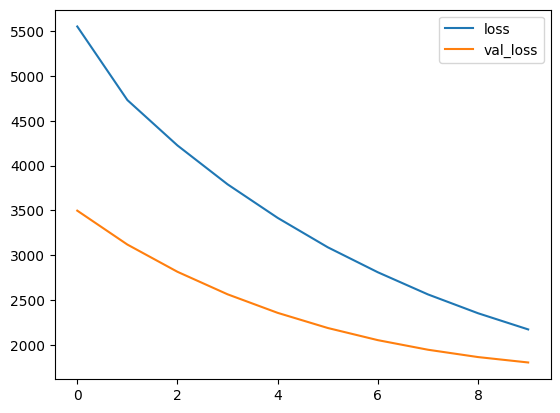

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

In [26]:
predictions = model.predict(X_rolled_test).flatten()

108/108 [==============================] - 5s 31ms/step


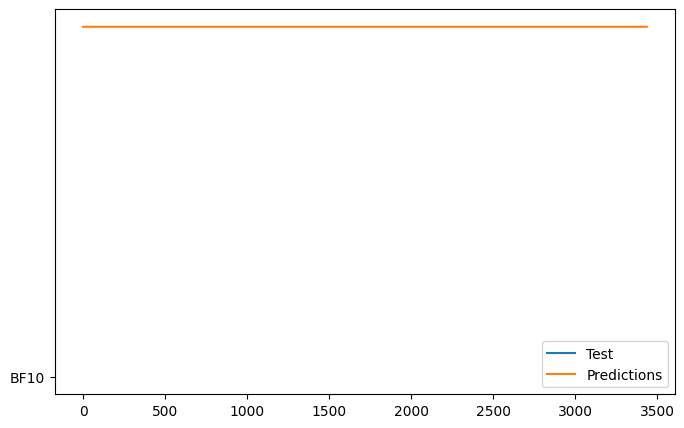

In [29]:
plt.figure(figsize=(8,5))
plt.plot(list(X_test[TIME_WINDOW:]), label="Test")
plt.plot(list(predictions), label="Predictions")
plt.legend()
plt.show()